In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import sys
import os
sys.path.append(os.path.abspath(".."))
from utils import *

In [2]:
year = 2023
rating_data_path = '/share/garg/311_data/sb2377_a_data/dcwp/Department_of_Consumer_and_Worker_Protection__DCWP__Inspections_20240710.csv'
report_data_path = '/share/garg/311_data/sb2377/data_{}.csv'.format(year)
covars_path = '/share/garg/311_data/sb2377/tract_demographics.csv'
save_path = '/share/garg/311_data/sb2377/processed_dcwp_{}.csv'.format(year)

In [3]:
reported_label = 'reported'
rename_map = {'Inspection Date': 'date'}

In [4]:
covariates_arr = pd.read_csv(covars_path)
df = pd.read_csv(rating_data_path)
df_311 = pd.read_csv(report_data_path)

/share/pierson/tmp_directory_location_please_read_readme/sb2377_tmp/ipykernel_599230/1621718016.py:3: DtypeWarning: Columns (8,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df_311 = pd.read_csv(report_data_path)


In [5]:
census_gdf, final_graph, census_gdf_raw = generate_graph_census()
census_gdf = census_gdf.to_crs('EPSG:2263')
block_gdf, final_graph, census_gdf_raw = generate_graph_census(census_unit='blocks')

Using the default year of 2021
Using FIPS code '36' for input 'NY'
Using FIPS code '061' for input 'New York'
Using FIPS code '005' for input 'Bronx'
Using FIPS code '047' for input 'Kings'
Using FIPS code '081' for input 'Queens'
Using FIPS code '085' for input 'Richmond'
Using the default year of 2021
Using FIPS code '36' for input 'NY'
Using FIPS code '061' for input 'New York'
Using FIPS code '005' for input 'Bronx'
Using FIPS code '047' for input 'Kings'
Using FIPS code '081' for input 'Queens'
Using FIPS code '085' for input 'Richmond'


In [6]:
# process rating data
# rename columns
df = df.rename(columns=rename_map)

# process date
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df['year'] = df['date'].dt.year
df['week'] = df['date'].dt.isocalendar().week
df['month'] = df['date'].dt.month
df.loc[(df['month'] == 1) & (df['week'] > 50), 'week'] = 0 # start first week at 0 (instead of previous year's indexing)
one_year_df = df[df['year'] == year]

# get census tract information
one_year_df = one_year_df.dropna(subset=['Latitude', 'Longitude'])
one_year_df = one_year_df[(one_year_df['Latitude'] != 0) & (one_year_df['Longitude'] != 0)]
one_year_gdf = gpd.GeoDataFrame(one_year_df,
                                geometry=gpd.points_from_xy(one_year_df.Longitude, one_year_df.Latitude),
                                crs='EPSG:4326')
one_year_gdf = gpd.sjoin(one_year_gdf.to_crs('EPSG:2263').reset_index(drop=True), block_gdf.to_crs('EPSG:2263'), how='inner', op='intersects')

# convert condition to numeric score
one_year_gdf = one_year_gdf.dropna(subset=['Inspection Result'])
one_year_gdf = one_year_gdf[one_year_gdf['Inspection Result'].isin(['Fail', 
                                                                    'NOH Withdrawn', 
                                                                    'No Violation Issued', 
                                                                    'No Warning Issued', 
                                                                    'Pass', 
                                                                    'Re-inspection', 
                                                                    'Violation Issued', 
                                                                    'Warning'])]
score_map = {'Fail':0, 
             'NOH Withdrawn':1, 
             'No Violation Issued':1, 
             'No Warning Issued':1, 
             'Pass':1, 
             'Re-inspection':0, 
             'Violation Issued':0, 
             'Warning':0
            }
one_year_gdf['score'] = one_year_gdf['Inspection Result'].map(score_map)

# get average score for each bbl each week
one_year_gdf = one_year_gdf[['GEOID20', 'week', 'score']]
one_year_gdf = one_year_gdf.groupby(['GEOID20', 'week']).mean().reset_index()

rating_df = one_year_gdf

/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [7]:
# process reporting data
# get data for type
type_df = df_311[df_311['Agency'] == 'DCWP']
type_df = df_311[df_311['Complaint Type'] == 'Consumer Complaint']
type_df['Created Date'] = pd.to_datetime(type_df['Created Date'])
type_df['week'] = type_df['Created Date'].dt.isocalendar().week
type_df['month'] = type_df['Created Date'].dt.month
type_df.loc[(type_df['month'] == 1) & (type_df['week'] > 50), 'week'] = 0 # start first week at 0 (instead of previous year's indexing)

# process location
type_df = type_df[~(type_df.Latitude.isna()|type_df.Longitude.isna())]
type_gdf = gpd.GeoDataFrame(type_df,
                            geometry=gpd.points_from_xy(type_df.Longitude, type_df.Latitude),
                            crs='EPSG:4326')

# get census tract information
type_gdf = gpd.sjoin(type_gdf.to_crs('EPSG:2263').reset_index(drop=True), block_gdf.to_crs('EPSG:2263'), how='inner', op='intersects')
type_gdf['GEOID20'] = type_gdf['GEOID20'].astype(int)
type_gdf = type_gdf.to_crs('EPSG:2263')

reports_df = type_gdf

# only get reports in a census block with an inspection
rating_df['GEOID20'] = rating_df['GEOID20'].astype(int)
rating_geoid = set(rating_df['GEOID20'].unique())
inspected_reports_df = reports_df[reports_df['GEOID20'].isin(rating_geoid)]

/share/pierson/tmp_directory_location_please_read_readme/sb2377_tmp/ipykernel_599230/4021108397.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  type_df['Created Date'] = pd.to_datetime(type_df['Created Date'])
/share/pierson/tmp_directory_location_please_read_readme/sb2377_tmp/ipykernel_599230/4021108397.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  type_df['Created Date'] = pd.to_datetime(type_df['Created Date'])
/share/pierson/tmp_directory_location_please_read_readme/sb2377_tmp/ipykernel_599230/4021108397.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [8]:
# create num finegrained entities x num weeks full T and r dataset
inspected_reports_df['finegrained_id'] = inspected_reports_df['GEOID20']
rating_df['finegrained_id'] = rating_df['GEOID20']
finegrained_entities = rating_df['finegrained_id'].unique()

dfs = []
for i in sorted(inspected_reports_df['week'].unique()):
    data = pd.DataFrame()
    data['finegrained_id'] = finegrained_entities
    data['report_week'] = i
    dfs.append(data)
    
all_data = pd.concat(dfs)

# add in T labels
# set T = 1 for instances where there is a complaint
inspected_reports_df['report_week'] = inspected_reports_df['week']
inspected_reports_df = inspected_reports_df[['finegrained_id', 'report_week']].drop_duplicates()
inspected_reports_df['reported'] = 1
all_data = pd.merge(all_data, inspected_reports_df, on=['finegrained_id', 'report_week'], how='left')
all_data['reported'] = all_data['reported'].fillna(0)

# add in rating data
rating_df['rating_week'] = rating_df['week']
rating_df['report_week'] = rating_df['week']
rating_subset_df = rating_df[['finegrained_id', 'score', 'rating_week', 'report_week']].drop_duplicates()
all_data = pd.merge(all_data, rating_subset_df, on=['finegrained_id', 'report_week'], how='left')

# assume constant rating until next inspection 
all_data.sort_values(by=['finegrained_id', 'report_week'], inplace=True)
all_data['score'] = all_data.groupby('finegrained_id')['score'].ffill()
all_data['rating_week'] = all_data.groupby('finegrained_id')['rating_week'].ffill()
all_data = all_data[::-1]
all_data['score'] = all_data.groupby('finegrained_id')['score'].ffill()
all_data['rating_week'] = all_data.groupby('finegrained_id')['rating_week'].ffill()
all_data = all_data[::-1]

# add in demographic data
all_data['GEOID'] = all_data['finegrained_id'].astype(str).str[:11]
all_data['GEOID'] = all_data['GEOID'].astype(int)
all_data = pd.merge(all_data, covariates_arr, on=['GEOID'], how='left')

# add in meta data
all_data['rating_week_of_year'] = all_data['rating_week']
all_data['report_week_of_year'] = all_data['report_week']

# get z-scored ratings
all_data['normalized_score'] = (all_data['score'] - all_data['score'].mean()) / all_data['score'].std()

/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/share/pierson/conda_virtualenvs/networks_underreporting_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [9]:
assert(len(finegrained_entities) * len(inspected_reports_df['report_week'].unique()) == len(all_data))

In [10]:
len(all_data)

86920

In [12]:
all_data.to_csv(save_path)

In [11]:
# evaluate mean rating with and without a report
mean_1 = all_data[(all_data[reported_label] == 1)]['score'].mean()
error_1 = all_data[(all_data[reported_label] == 1)]['score'].std() / len(all_data)
mean_0 = all_data[(all_data[reported_label] == 0)]['score'].mean()
error_0 = all_data[(all_data[reported_label] == 0)]['score'].std() / len(all_data)
print('Mean rating of tracts with a report = {}, without a report = {}'.format(mean_1, mean_0))
print('95% CIs rating of tracts with a report = [{}, {}], without a report = [{}, {}]'.format(mean_1 - 1.96 * error_1, mean_1 + 1.96 * error_1, mean_0 - 1.96 * error_0, mean_0 + 1.96 * error_0))

Mean rating of tracts with a report = 0.40630852636766873, without a report = 0.4393787260746784
95% CIs rating of tracts with a report = [0.40629765360256986, 0.4063193991327676], without a report = [0.43936774940716067, 0.4393897027421962]


Optimization terminated successfully.
         Current function value: 0.187527
         Iterations 7


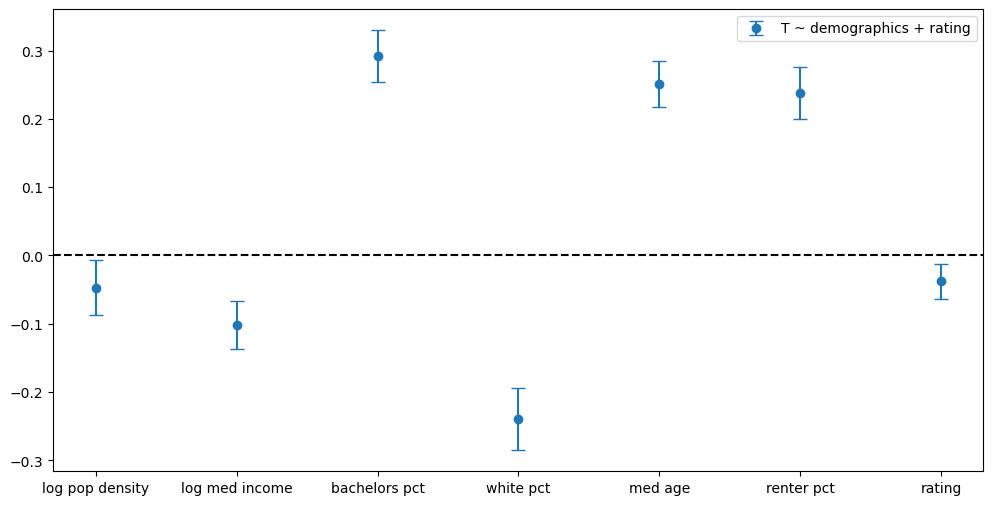

In [12]:
# run a regression of T ~ demographics + rating
covariates = ['log pop density',
              'log med income',
              'bachelors pct',
              'white pct',
              'med age',
              'renter pct'
             ]

normalized_covariates = ['normalized_log_population_density',
                         'normalized_log_income_median',
                         'normalized_education_bachelors_pct',
                         'normalized_race_white_nh_pct',
                         'normalized_age_median',
                         'normalized_households_renteroccupied_pct',
                         'normalized_score'
                        ]

plt.figure(figsize=(12, 6))

y_label = reported_label
formula = y_label + ' ~ '
for c in normalized_covariates:
    formula += c + ' + '
formula = formula[:-3]

fit = sm.Logit.from_formula(formula, data = all_data).fit()
fit.summary()
coefficients = fit.params.to_numpy()[-7:]
conf_intervals = fit.conf_int().to_numpy()[-7:, :]
plt.errorbar(x=covariates + ['rating'], y=coefficients, 
             yerr=[coefficients - conf_intervals[:,0], conf_intervals[:,1] - coefficients], capsize=5, fmt='o', label='T ~ demographics + rating')

plt.axhline(0, color='black', linestyle='--')  # Horizontal dashed line at y=0
plt.legend()
plt.show()